<a href="https://colab.research.google.com/github/mcvlix/lorenz-96-hybrid-esn/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# === Mount your Drive ===
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# === Libraries ===
import sys
import numpy as np
import cupy as cp
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as sio
import os
from tqdm import tqdm
from tqdm import trange
import torch
import matplotlib.pyplot as plt
import scipy.sparse as sparse
from scipy.sparse import linalg
from pathlib import Path
import gc
import pickle

In [3]:
# === Paths ===
project_path = '/content/drive/My Drive/AM170B Project'
data_path = os.path.join(project_path, 'data')
hybrid_states_path = os.path.join(project_path, 'hybrid_states')
states_path = os.path.join(project_path, 'states')
checkpoints_path = os.path.join(project_path, 'checkpoints')
models_path = os.path.join(project_path, 'models')
predictions_path = os.path.join(project_path, 'predictions')
plots_path = os.path.join(project_path, 'plots')
os.makedirs(states_path, exist_ok=True)
os.makedirs(checkpoints_path, exist_ok=True)
os.makedirs(models_path, exist_ok=True)
os.makedirs(predictions_path, exist_ok=True)
os.makedirs(plots_path, exist_ok=True)

In [4]:
# === View Memory Usage ===
def whos_memory(namespace):
    exclude = {
        'np', 'pd', 'plt', 'os', 'gc', 'sys', 'sio', 'tqdm', 'torch', 'sparse', 'Path',
        'exit', 'quit', 'open', 'get_ipython', 'whos_memory'
    }
    print(f"{'Variable':20} {'Type':15} {'Size (MB)':>10}")
    print("-" * 50)
    for name, val in namespace.items():
        if name.startswith("_") or name in exclude:
            continue
        try:
            size = sys.getsizeof(val) / 1024 / 1024
            print(f"{name:20} {type(val).__name__:15} {size:10.4f}")
        except Exception:
            print(f"{name:20} {type(val).__name__:15} {''}")

# del
whos_memory(globals())

Variable             Type             Size (MB)
--------------------------------------------------
In                   list                0.0001
Out                  dict                0.0001
drive                module              0.0001
cp                   module              0.0001
trange               function            0.0001
linalg               module              0.0001
pickle               module              0.0001
project_path         str                 0.0001
data_path            str                 0.0001
hybrid_states_path   str                 0.0001
states_path          str                 0.0001
checkpoints_path     str                 0.0001
models_path          str                 0.0001
predictions_path     str                 0.0001
plots_path           str                 0.0001


### Data

In [5]:
X_true  = np.load(os.path.join(data_path, 'truth_h_0.5_c_8_F_20.npy'))[0:1000, :8].T

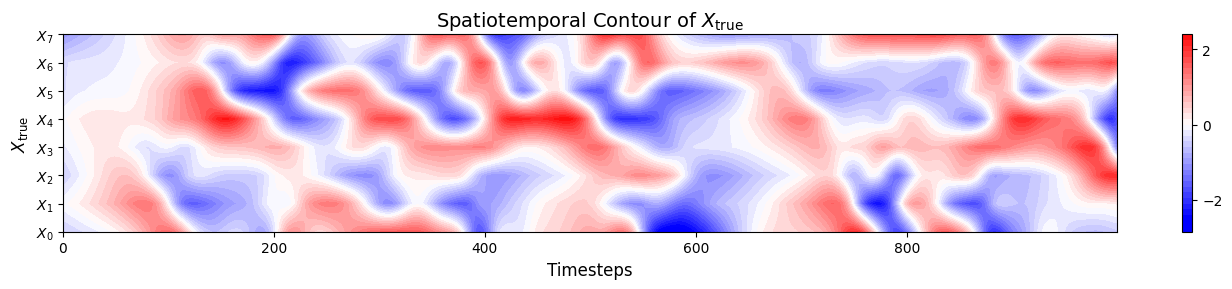

In [6]:
# === Slice 1000 steps ===
steps = 1000

# === Axes ===
time_axis = np.arange(steps)  # use explicit timestep index
space_axis = np.arange(8)

# === Contour Plot ===
fig, ax = plt.subplots(figsize=(14, 3))
contour = ax.contourf(time_axis, space_axis, X_true, levels=50, cmap='bwr', vmin=-2.5, vmax=2.5)

# === Labels ===
ax.set_title("Spatiotemporal Contour of $X_{\\mathrm{true}}$", fontsize=14)
ax.set_xlabel("Timesteps", fontsize=12)
ax.set_ylabel("$X_{\\mathrm{true}}$", fontsize=12)
ax.set_yticks(space_axis)
ax.set_yticklabels([f"$X_{{{i}}}$" for i in space_axis])

# === Colorbar ===
cbar = fig.colorbar(contour, ax=ax)
cbar.set_ticks([-2, 0, 2])

plt.tight_layout()
plt.show()

### Imperfect Model

In [16]:
X_model = np.load(os.path.join(data_path, 'X_model_full.npz'))['X_model'][500001:501001].T          # shape (8, 1000)
X_true  = np.load(os.path.join(data_path, 'truth_h_0.5_c_8_F_20.npy'))[500001:501001, :8].T         # shape (8, 1000)
X_diff = X_true - X_model                                                                           # shape (8, 1000)

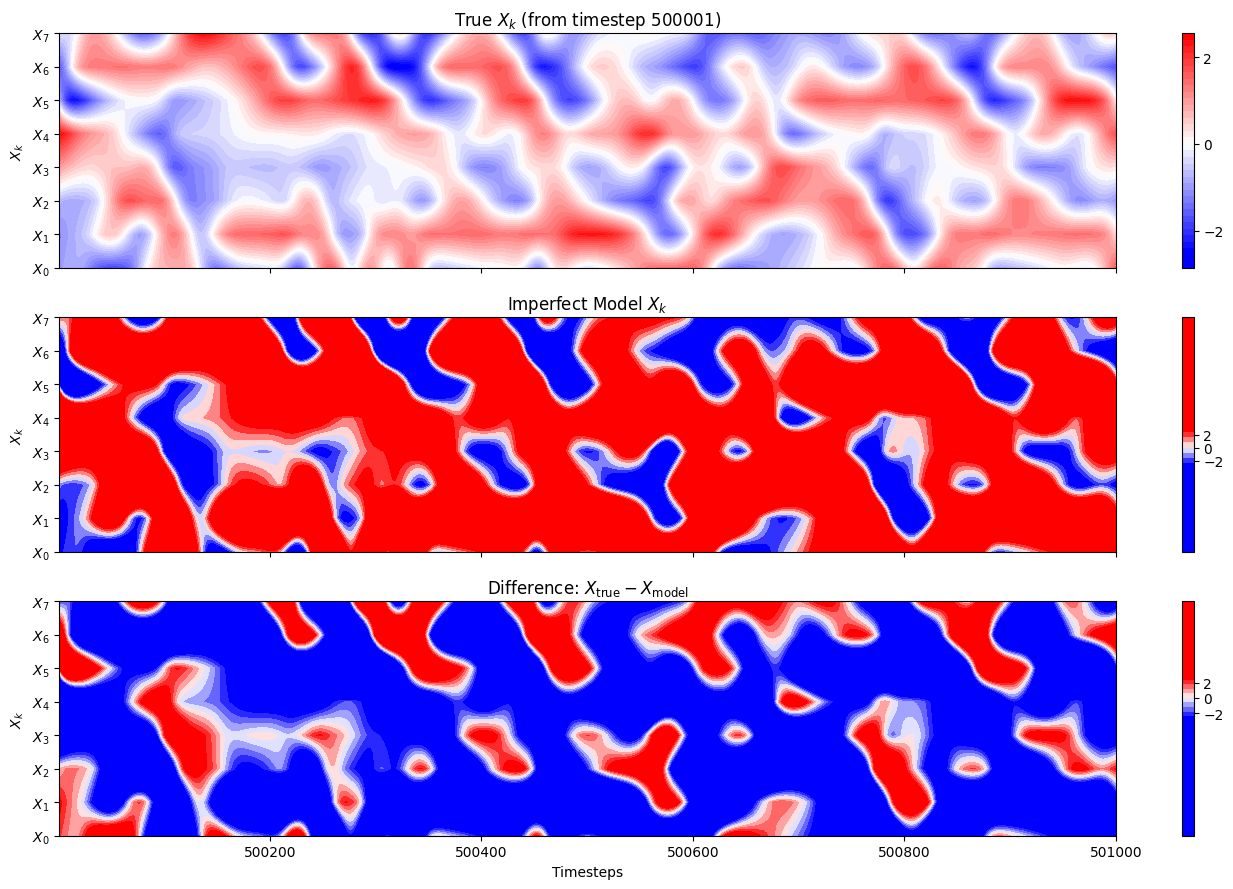

In [17]:
start = 500001
time_axis = np.arange(start, start + X_true.shape[1])
space_axis = np.arange(X_true.shape[0])

fig, axs = plt.subplots(3, 1, figsize=(14, 9), sharex=True)

# --- Ground truth ---
c1 = axs[0].contourf(time_axis, space_axis, X_true, levels=50, cmap='bwr', vmin=-2.5, vmax=2.5)
axs[0].set_title("True $X_k$ (from timestep {})".format(start))
axs[0].set_ylabel("$X_k$")
axs[0].set_yticks(space_axis)
axs[0].set_yticklabels([f"$X_{{{i}}}$" for i in space_axis])
fig.colorbar(c1, ax=axs[0], ticks=[-2, 0, 2])

# --- Imperfect Model ---
c2 = axs[1].contourf(time_axis, space_axis, X_model, levels=50, cmap='bwr', vmin=-2.5, vmax=2.5)
axs[1].set_title("Imperfect Model $X_k$")
axs[1].set_ylabel("$X_k$")
axs[1].set_yticks(space_axis)
axs[1].set_yticklabels([f"$X_{{{i}}}$" for i in space_axis])
fig.colorbar(c2, ax=axs[1], ticks=[-2, 0, 2])

# --- Difference ---
c3 = axs[2].contourf(time_axis, space_axis, X_diff, levels=50, cmap='bwr', vmin=-2.5, vmax=2.5)
axs[2].set_title("Difference: $X_{\\text{true}} - X_{\\text{model}}$")
axs[2].set_xlabel("Timesteps")
axs[2].set_ylabel("$X_k$")
axs[2].set_yticks(space_axis)
axs[2].set_yticklabels([f"$X_{{{i}}}$" for i in space_axis])
fig.colorbar(c3, ax=axs[2], ticks=[-2, 0, 2])

plt.tight_layout()
plt.show()

### ESN

In [18]:
# === Parameters ===
shift_k = 0  # Start index for initial condition
approx_res_size = 5000

model_params = {
    'tau': 0.25,
    'nstep': 1000,
    'N': 8,
    'd': 22
}

res_params = {
    'radius': 0.1,
    'degree': 3,
    'sigma': 0.5,
    'train_length': 500000,
    'N': int(np.floor(approx_res_size / model_params['N']) * model_params['N']),
    'num_inputs': model_params['N'],
    'predict_length': 1000,
    'beta': 0.0001
}

In [19]:
def predict_esn(A, Win, res_params, last_state, W_out, initial_output):
    """
    Predict future dynamics using the trained ESN model.
    - last_state: final state from training (N,)
    - initial_output: last known input (num_inputs,) to bootstrap prediction
    Returns:
        - predictions: shape (num_inputs, predict_length)
    """
    N = res_params['N']
    num_inputs = res_params['num_inputs']
    T = res_params['predict_length']

    x = last_state.copy()
    output = np.zeros((num_inputs, T))
    out = initial_output.copy()

    for t in tqdm(range(T), desc="Predicting"):
        # Augment state for nonlinear transformation
        x_aug = x.copy()
        for j in range(2, len(x_aug) - 2):
            if j % 2 == 0:
                x_aug[j] = x[j - 1] * x[j - 2]

        out = np.dot(W_out, x_aug).squeeze()
        output[:, t] = out
        x = np.tanh(A @ x + Win @ out)

    return output

In [20]:
# Load model
model = np.load(os.path.join(models_path, 'model_500000.npz'))
A = model['A']
Win = model['Win']
W_out = model['W_out']

# Prediction config
res_params['predict_length'] = 1000
start = 500001  # start prediction immediately after training

# Load data and initial input
npy_path = os.path.join(data_path, 'truth_h_0.5_c_8_F_20.npy')
data = np.load(npy_path, mmap_mode='r')
X_true = data[start:start + res_params['predict_length'], :res_params['num_inputs']].T
initial_output = data[start - 1, :res_params['num_inputs']]

# Load final reservoir state from last training chunk
last_state_file = os.path.join(states_path, f'states_chunk_009.npz')  # 10th chunk (index 0–9)
last_state = np.load(last_state_file)['states'][:, -1]

# Run prediction
X_pred = predict_esn(A, Win, res_params, last_state, W_out, initial_output)
X_diff = X_true - X_pred

Predicting: 100%|██████████| 1000/1000 [00:06<00:00, 165.33it/s]


In [21]:
np.savez_compressed(
    os.path.join(predictions_path, f'prediction_start{start}_len{res_params["predict_length"]}.npz'),
    X_true=X_true,
    X_pred=X_pred,
    X_diff=X_diff,
    start=start,
    length=res_params['predict_length']
)

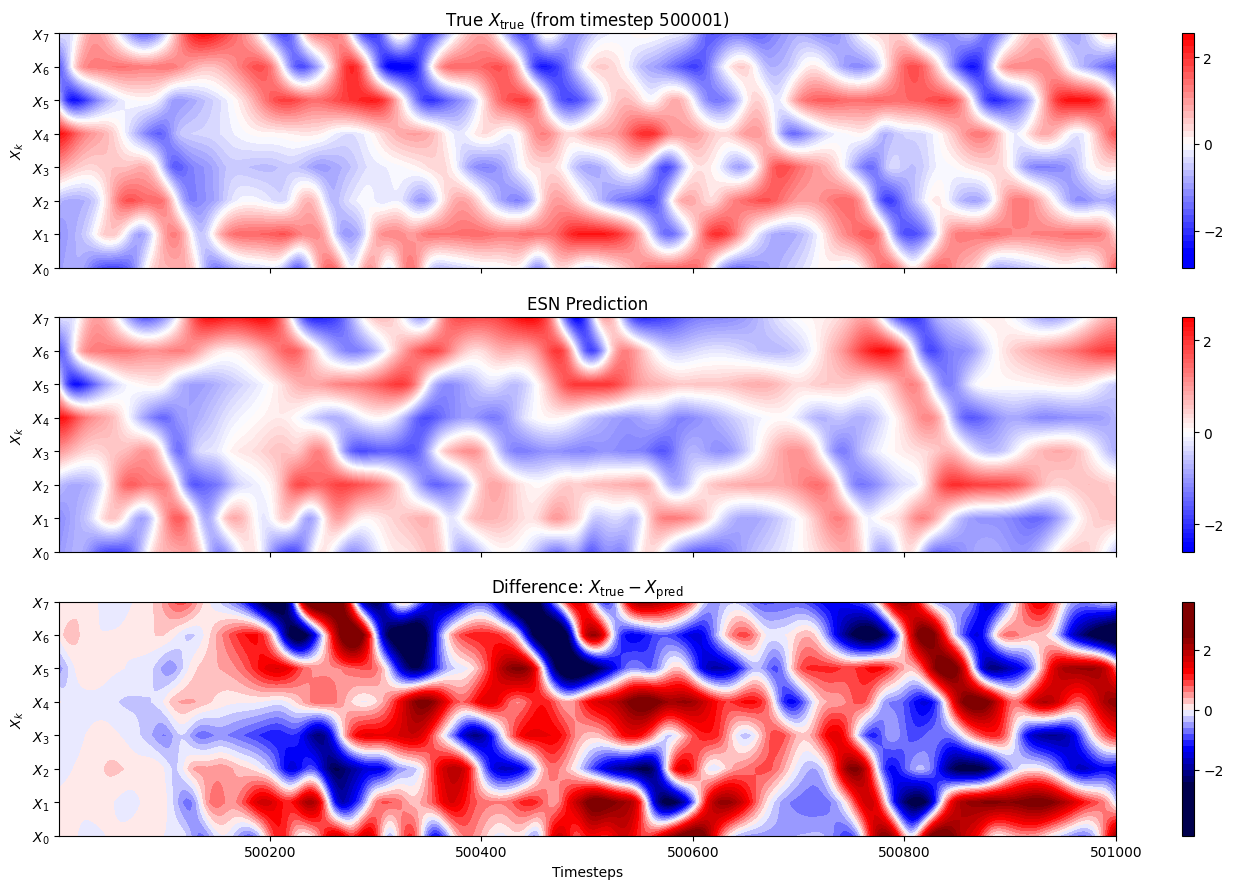

✅ Saved plot to /content/drive/My Drive/AM170B Project/plots/prediction_plot_start500001_len1000.png


In [23]:
# === Plotting ===
time_axis = np.arange(start, start + res_params['predict_length'])
space_axis = np.arange(res_params['num_inputs'])

fig, axs = plt.subplots(3, 1, figsize=(14, 9), sharex=True)

# --- True ---
c1 = axs[0].contourf(time_axis, space_axis, X_true, levels=50, cmap='bwr', vmin=-2.5, vmax=2.5)
axs[0].set_title("True $X_{\\mathrm{true}}$ (from timestep 500001)")
axs[0].set_ylabel("$X_k$")
axs[0].set_yticks(space_axis)
axs[0].set_yticklabels([f"$X_{{{i}}}$" for i in space_axis])
cb1 = fig.colorbar(c1, ax=axs[0])
cb1.set_ticks([-2, 0, 2])

# --- Predicted ---
c2 = axs[1].contourf(time_axis, space_axis, X_pred, levels=50, cmap='bwr', vmin=-2.5, vmax=2.5)
axs[1].set_title("ESN Prediction")
axs[1].set_ylabel("$X_k$")
axs[1].set_yticks(space_axis)
axs[1].set_yticklabels([f"$X_{{{i}}}$" for i in space_axis])
cb2 = fig.colorbar(c2, ax=axs[1])
cb2.set_ticks([-2, 0, 2])

# --- Difference ---
c3 = axs[2].contourf(time_axis, space_axis, X_diff, levels=50, cmap='seismic', vmin=-2.5, vmax=2.5)
axs[2].set_title("Difference: $X_{\\mathrm{true}} - X_{\\mathrm{pred}}$")
axs[2].set_xlabel("Timesteps")
axs[2].set_ylabel("$X_k$")
axs[2].set_yticks(space_axis)
axs[2].set_yticklabels([f"$X_{{{i}}}$" for i in space_axis])
cb3 = fig.colorbar(c3, ax=axs[2])
cb3.set_ticks([-2, 0, 2])

# === Save plot ===
plot_filename = f'prediction_plot_start{start}_len{res_params["predict_length"]}.png'
plt.tight_layout()
plt.savefig(os.path.join(plots_path, plot_filename), dpi=300)
plt.show()

print(f"✅ Saved plot to {os.path.join(plots_path, plot_filename)}")

### Hybrid ESN

### Imperfect Model + EnKF

### ESN + EnKF

### Hybrid ESN + EnKF